### Load data

In [1]:
import pandas as pd
import numpy as np
predictions = pd.read_csv("./data/predictions_up.csv")
predictions.head()

,label,predReg,predGbt,predReg_up
0,0,0.000048,0.000553,0.021381
1,0,0.000298,0.004249,0.005709
2,0,0.005385,0.003387,0.042259
3,0,0.011068,0.010059,0.683194
4,0,0.000002,0.000487,0.017195


### Task 4.1 - Brier Score

In [2]:
def brierScore(df, modelName):
    return np.average((df["label"].values - df[modelName].values) ** 2)

brier_reg = brierScore(predictions, "predReg")
brier_reg_up = brierScore(predictions, "predReg_up")
brier_gbt = brierScore(predictions, "predGbt")

print("Brier Score of LogReg is:", brier_reg)
print("Brier Score of Upsampled LogReg is:", brier_reg_up)
print("Brier Score of GBT is:", brier_gbt)

Brier Score of LogReg is: 0.007121913033017399
Brier Score of Upsampled LogReg is: 0.08715447691828844
Brier Score of GBT is: 0.009589360307732386


### Task 4.2 - Calibration Plot

In [3]:
def calibrationError(predictions, modelName, bucketSize=100):
    p_sorted = predictions.sort_values(by=[modelName]).reset_index(drop=True)
    p_sorted["bucket_num"] = p_sorted.index.map(lambda x: x // bucketSize)
    p_mean = p_sorted.groupby(by='bucket_num').mean()
    return (p_mean["label"], p_mean[modelName])

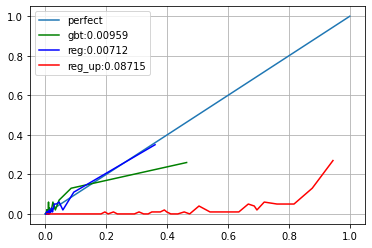

In [4]:
p_predicted_gbt, p_real_gbt = calibrationError(predictions, "predGbt")
p_predicted_reg, p_real_reg = calibrationError(predictions, "predReg")
p_predicted_regup, p_real_regup = calibrationError(predictions, "predReg_up")

import matplotlib.pyplot as plt
plt.figure()
plt.plot([0, 1], [0, 1], label = "perfect")
plt.plot(p_real_gbt, p_predicted_gbt, color='g', label=f"gbt:{brier_gbt:.5f}")
plt.plot(p_real_reg, p_predicted_reg, color='b', label=f"reg:{brier_reg:.5f}")
plt.plot(p_real_regup, p_predicted_regup, color='r', label=f"reg_up:{brier_reg_up:.5f}")
plt.legend()
plt.grid()
plt.show()

### Task 4.3 - Probability Calibration

In [5]:
train_data = pd.read_pickle("./data/train_upsampled.pickle")
X_train = train_data.drop("returnLabel", axis=1)
y_train = train_data["returnLabel"]

In [12]:
train_data

,totalAmount,returnLabel,c_0,c_1,c_2,c_3,c_4,c_5,100,101,...,991,992,993,994,995,996,997,998,999,1000
0,192,0,0,2,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,96,0,0,1,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,67,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,93,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,171,0,0,0,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21695,60,0,1,1,0,1,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21696,55,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21697,120,0,0,4,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21698,304,0,1,1,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=5000)

In [7]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=logreg)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=LogisticRegression(max_iter=5000))

In [11]:
from joblib import dump, load
dump(calibrated_clf, 'calibrated_logistic_regression_classifier.joblib') 

['calibrated_logistic_regression_classifier.joblib']

In [8]:
# test 
test_data = pd.read_pickle("./data/test.pickle")
X_test = test_data.drop("returnLabel", axis=1)
y_test = test_data["returnLabel"]
test_scores = calibrated_clf.predict_proba(X_test)

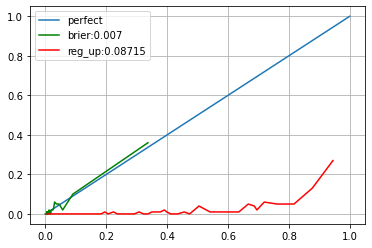

In [9]:
df = pd.DataFrame(data={'label': y_test, 'pred': test_scores[:,1]}).reset_index(drop=True)
return_rate, scores = calibrationError(df, "pred")
brier = brierScore(df, "pred")

plt.figure()
plt.plot([0, 1], [0, 1], label = "perfect")
plt.plot(scores, return_rate, color = 'g', label = f"brier:{brier:.3f}")
plt.plot(p_real_regup, p_predicted_regup, color='r', label=f"reg_up:{brier_reg_up:.5f}")
plt.legend()
plt.grid()
plt.show()